## Intro

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import shared_utils

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

## Agreement Allocations - Read in Raw data

In [2]:
url = "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/TIRCP Tracking Sheets 2_1-10-2024.xlsx"
sheet_name = "Agreement Allocations"

In [17]:
tircp = pd.read_excel(url, sheet_name)

## Agreement Allocations -Data Cleaning and QC

In [18]:
# reducing initialdf to first 11 columns.
tircp = tircp.iloc[:, :12]

In [19]:
# dictionary for column name update
new_col = [
    "award_year",
    "project_#",
    "grant_recipient",
    "implementing_agency",
    "ppno",
    "project_id",
    "ea",
    "components",
    "#_of_buses",
    "phase",
    "allocation_amount",
    "expended_amount",
]

In [20]:
tircp.columns = new_col
tircp.columns

Index(['award_year', 'project_#', 'grant_recipient', 'implementing_agency',
       'ppno', 'project_id', 'ea', 'components', '#_of_buses', 'phase',
       'allocation_amount', 'expended_amount'],
      dtype='object')

In [21]:
tircp = tircp.drop("expended_amount", axis=1)

In [22]:
# fill NaN with zero?
# see if you can sum the bus column
tircp.agg({"#_of_buses": "sum"})
# nope this is correct

#_of_buses    527.0
dtype: float64

In [23]:
display(tircp.shape, list(tircp.columns), tircp.head())

(726, 11)

['award_year',
 'project_#',
 'grant_recipient',
 'implementing_agency',
 'ppno',
 'project_id',
 'ea',
 'components',
 '#_of_buses',
 'phase',
 'allocation_amount']

,award_year,project_#,grant_recipient,implementing_agency,ppno,project_id,ea,components,#_of_buses,phase,allocation_amount
0,2018.0,28.0,Transportation Agency for Monterey County,Transportation Agency for Monterey County,1155,NaN,NaN,New Passenger Rail Service to Salinas,NaN,CONST,0
1,2018.0,28.0,Transportation Agency for Monterey County,Transportation Agency for Monterey County,1155,NaN,NaN,Positive Train Control,NaN,CONST,0
2,2016.0,11.0,San Bernardino County Transportation Authority...,San Bernardino County Transportation Authority...,1230,19000086.0,R391GD,Construct New Rail System Linking San Bernardi...,NaN,CONST,9204000
3,2020.0,10.0,San Bernardino County Transportation Authority...,San Bernardino County Transportation Authority,1232,23000073.0,T458GA,Acquisition of Zero-Emission Buses,NaN,CONST,15000000
4,2018.0,19.0,San Joaquin Joint Powers Authority and San Joa...,San Joaquin Regional Rail Commission,10-9883,NaN,NaN,Stockton Diamond,NaN,CONST,0


In [26]:
tircp.grant_recipient.nunique()

96

In [27]:
# use strip to help combine names
tircp["grant_recipient"] = tircp["grant_recipient"].str.strip()

tircp.grant_recipient.nunique()

90

In [36]:
# see list of unique names
# may be able to consolidate a few
tircp.grant_recipient.sort_values().unique()

array(['.', 'Alameda Contra Costa Transit District',
       'Anaheim Transportation Network (ATN)',
       'Antelope Valley Air Quality Management District',
       'Antelope Valley Transit Authority',
       'Antelope Valley Transit Authority & Long Beach Transit',
       'Antelope Valley Transit Authority (AVTA)',
       'Bay Area Rapid Transit (BART)', 'Bay Area Rapid Transit District',
       'Capitol Corridor Joint Powers Authority',
       'Capitol Corridor Joint Powers Authority (CCJPA)',
       'Capitol Corridor Joint Powers Authority (CCJPA)  with City of Sacramento, Sacramento Area Council of Governments (SACOG), and Sacramento Regional Transit District (SacRT)',
       'Capitol Corridor Joint Powers Authority (CCJPA) with City of Sacramento, City of Hercules, and Santa Cruz Metropolitan Transit District',
       'City of Cupertino', 'City of Fresno',
       'City of Glendale and Arroyo Verdugo Communities',
       'City of Inglewood', 'City of Los Angeles', 'City of Oakland'

In [37]:
new_dict = {
    "Antelope Valley Transit Authority": "Antelope Valley Transit Authority (AVTA)",
    "Bay Area Rapid Transit District": "Bay Area Rapid Transit (BART)",
    "Capitol Corridor Joint Powers Authority": "Capitol Corridor Joint Powers Authority (CCJPA)",
    "Los Angeles County Metropolitan Transportation (LA Metro)": "Los Angeles County Metropolitan Transportation Authority (LA Metro)",
    "Los Angeles County Metropolitan Transportation Authority": "Los Angeles County Metropolitan Transportation Authority (LA Metro)",
    "Sacramento Regional Transit (SacRT)": "Sacramento Regional Transit District (SacRT)",
    "Sacramento Regional Transit District": "Sacramento Regional Transit District (SacRT)",
    "San Diego Metropolitan Transit System (SDMTS)": "San Diego Metropolitan Transit System (MTS)",
    "San Francisco Bay Area Water Emergency Transportation Authority": "San Francisco Bay Area Water Emergency Transportation Authority (WETA)",
    "San Francisco Municipal Transportation Agency": "San Francisco Municipal Transportation Authority (SFMTA)",
    "Santa Barbara County Association of Governments\n(SBCAG)": "Santa Barbara County Association of Governments (SBCAG)",
    "Santa Clara Valley Transportation Authority": "Santa Clara Valley Transportation Authority (VTA)",
    "Transportation Agency for Monterey County": "Transportation Agency for Monterey County (TAMC)",
}

In [46]:
# replace the values in grant_recipient using dict
# df.replace({'bus_desc': new_dict}, inplace=True)
tircp = tircp.replace({"grant_recipient": new_dict})

In [51]:
#see that some rows were consolidated
display(tircp.grant_recipient.nunique())

77

## Agreement Allocations-Export Cleaned data

In [52]:
tircp.to_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_allocations_clean.csv"
)

## Agreement Allocations-Read in Cleaned data from GCS

In [53]:
tircp = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_allocations_clean.csv"
)

In [54]:
display(tircp.shape, tircp.columns, tircp.head())

(726, 12)

Index(['Unnamed: 0', 'award_year', 'project_#', 'grant_recipient',
       'implementing_agency', 'ppno', 'project_id', 'ea', 'components',
       '#_of_buses', 'phase', 'allocation_amount'],
      dtype='object')

,Unnamed: 0,award_year,project_#,grant_recipient,implementing_agency,ppno,project_id,ea,components,#_of_buses,phase,allocation_amount
0,0,2018.0,28.0,Transportation Agency for Monterey County (TAMC),Transportation Agency for Monterey County,1155,NaN,NaN,New Passenger Rail Service to Salinas,NaN,CONST,0
1,1,2018.0,28.0,Transportation Agency for Monterey County (TAMC),Transportation Agency for Monterey County,1155,NaN,NaN,Positive Train Control,NaN,CONST,0
2,2,2016.0,11.0,San Bernardino County Transportation Authority...,San Bernardino County Transportation Authority...,1230,19000086.0,R391GD,Construct New Rail System Linking San Bernardi...,NaN,CONST,9204000
3,3,2020.0,10.0,San Bernardino County Transportation Authority...,San Bernardino County Transportation Authority,1232,23000073.0,T458GA,Acquisition of Zero-Emission Buses,NaN,CONST,15000000
4,4,2018.0,19.0,San Joaquin Joint Powers Authority and San Joa...,San Joaquin Regional Rail Commission,10-9883,NaN,NaN,Stockton Diamond,NaN,CONST,0


## Agreement Allocations-Cost per Bus, per agency

In [55]:
# filer to project with bus count values
# caveat: some rows in "component" column state some variation of "purchased buses", but did not specify the amount of buses. 
# only rows stating the specificy number of buses purchased are included
only_bus = tircp[tircp['#_of_buses']>0]


In [57]:
display(only_bus.shape)

(46, 12)

In [60]:
#aggregate # of buses and allocation by transit agency
bus_cost = only_bus.groupby('grant_recipient').agg({
    '#_of_buses':"sum",
    'allocation_amount':'sum'
}).reset_index()

In [61]:
bus_cost

,grant_recipient,#_of_buses,allocation_amount
0,Anaheim Transportation Network (ATN),42.0,13776000
1,Antelope Valley Air Quality Management District,19.0,8930000
2,Antelope Valley Transit Authority & Long Beach...,12.0,11706000
3,Antelope Valley Transit Authority (AVTA),29.0,30378000
4,City of Glendale and Arroyo Verdugo Communities,22.0,0
5,City of Pasadena,20.0,0
6,City of Santa Monica,15.0,3050000
7,City of Simi Valley,6.0,4800000
8,City of Torrence,10.0,0
9,City of Wasco,6.0,650000


In [67]:
bus_cost['cost_per_bus']= ((bus_cost['allocation_amount'])/(bus_cost['#_of_buses'])).astype('int64')

In [80]:
display(bus_cost.dtypes,bus_cost)

grant_recipient       object
#_of_buses           float64
allocation_amount      int64
cost_per_bus           int64
dtype: object

,grant_recipient,#_of_buses,allocation_amount,cost_per_bus
0,Anaheim Transportation Network (ATN),42.0,13776000,328000
1,Antelope Valley Air Quality Management District,19.0,8930000,470000
2,Antelope Valley Transit Authority & Long Beach...,12.0,11706000,975500
3,Antelope Valley Transit Authority (AVTA),29.0,30378000,1047517
4,City of Glendale and Arroyo Verdugo Communities,22.0,0,0
5,City of Pasadena,20.0,0,0
6,City of Santa Monica,15.0,3050000,203333
7,City of Simi Valley,6.0,4800000,800000
8,City of Torrence,10.0,0,0
9,City of Wasco,6.0,650000,108333


In [81]:
#exporting cost per bus
bus_cost.to_csv("gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_allocation_cost_per_bus.csv")

## Agreement Allocations - Stat analysis

In [79]:
bus_cost

,grant_recipient,#_of_buses,allocation_amount,cost_per_bus
0,Anaheim Transportation Network (ATN),42.0,13776000,328000
1,Antelope Valley Air Quality Management District,19.0,8930000,470000
2,Antelope Valley Transit Authority & Long Beach...,12.0,11706000,975500
3,Antelope Valley Transit Authority (AVTA),29.0,30378000,1047517
4,City of Glendale and Arroyo Verdugo Communities,22.0,0,0
5,City of Pasadena,20.0,0,0
6,City of Santa Monica,15.0,3050000,203333
7,City of Simi Valley,6.0,4800000,800000
8,City of Torrence,10.0,0,0
9,City of Wasco,6.0,650000,108333


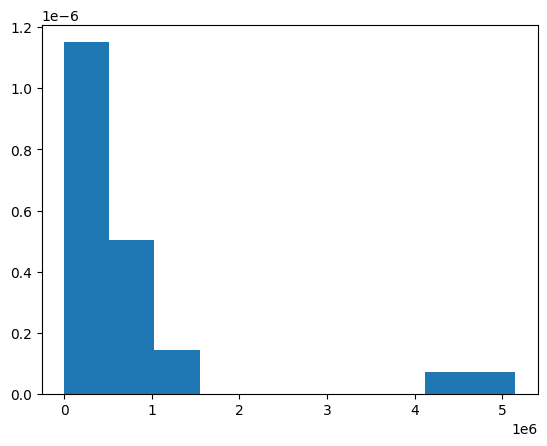

In [77]:
plt.figure(
plt.hist(bus_cost['cost_per_bus'],density=True)
plt.show()

## project tracking -  read raw data


In [124]:
url = "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/TIRCP Tracking Sheets 2_1-10-2024.xlsx"
sheet_name = "Project Tracking"

In [125]:
project = pd.read_excel(url, sheet_name)

/opt/conda/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [126]:
display(
    project.shape,
    project.columns,
    project.dtypes,
)

(124, 49)

Index(['Award Year', 'Project #', 'Grant Recipient', 'Project Title', 'PPNO',
       'District', 'County', 'Project Description', 'bus_count',
       'Master Agreement Number', 'Master Agreement Expiration Date',
       'Project Manager', 'Regional Coordinator',
       'Technical Assistance-CALITP (Y/N)', 'Technical Assistance-Fleet (Y/N)',
       'Technical Assistance-Network Integration (Y/N)',
       'Technical Assistance-Priority Population (Y/N)', 'Total Project Cost',
       'TIRCP Award Amount ($)', 'Allocated Amount', 'Unallocated Amount',
       'Percentage Allocated', 'Expended Amount', 'Other Funds Involved',
       'Award Cycle', 'Is SB1?', 'Is GGRF?', 'Is IIJA?', 'ON SHS?', 'CalITP',
       'Estimated TIRCP GHG Reductions', 'Estemated Project Completion',
       'Estimated TIRCP GHG Reductions2', 'Increased Ridership',
       'Service Integration', 'Improve Safety', 'Project Readiness',
       'Funding Leverage', 'Multi-Agency Coordination/Integration',
       'AB 1550 Com

Award Year                                          int64
Project #                                           int64
Grant Recipient                                    object
Project Title                                      object
PPNO                                               object
District                                           object
County                                             object
Project Description                                object
bus_count                                         float64
Master Agreement Number                            object
Master Agreement Expiration Date                   object
Project Manager                                    object
Regional Coordinator                               object
Technical Assistance-CALITP (Y/N)                  object
Technical Assistance-Fleet (Y/N)                   object
Technical Assistance-Network Integration (Y/N)     object
Technical Assistance-Priority Population (Y/N)     object
Total Project 

## Project Tracking- data cleaning

In [127]:
#drop columns
#tircp = tircp.iloc[:, :12]
project = project.iloc[:, :20]

In [128]:
list(project.columns)

['Award Year',
 'Project #',
 'Grant Recipient',
 'Project Title',
 'PPNO',
 'District',
 'County',
 'Project Description',
 'bus_count',
 'Master Agreement Number',
 'Master Agreement Expiration Date',
 'Project Manager',
 'Regional Coordinator',
 'Technical Assistance-CALITP (Y/N)',
 'Technical Assistance-Fleet (Y/N)',
 'Technical Assistance-Network Integration (Y/N)',
 'Technical Assistance-Priority Population (Y/N)',
 'Total Project Cost',
 'TIRCP Award Amount ($)',
 'Allocated Amount']

In [131]:
drop_col=[
 'Master Agreement Expiration Date',
 'Project Manager',
 'Regional Coordinator',
 'Technical Assistance-CALITP (Y/N)',
 'Technical Assistance-Fleet (Y/N)',
 'Technical Assistance-Network Integration (Y/N)',
 'Technical Assistance-Priority Population (Y/N)',]

In [132]:
project.drop(columns=drop_col, inplace=True)

In [133]:
list(project.columns)

['Award Year',
 'Project #',
 'Grant Recipient',
 'Project Title',
 'PPNO',
 'District',
 'County',
 'Project Description',
 'bus_count',
 'Master Agreement Number',
 'Total Project Cost',
 'TIRCP Award Amount ($)',
 'Allocated Amount']

In [134]:
#replace space with _
project.columns =project.columns.str.replace(' ','_')

In [135]:
#lower case everything
project.columns=project.columns.str.lower()

In [136]:
#check work
project.columns

Index(['award_year', 'project_#', 'grant_recipient', 'project_title', 'ppno',
       'district', 'county', 'project_description', 'bus_count',
       'master_agreement_number', 'total_project_cost',
       'tircp_award_amount_($)', 'allocated_amount'],
      dtype='object')

### filter df for project descriptions that contain bus

In [142]:
bus_only = project[project['bus_count']>0]

In [143]:
#this looks correct
display(project.shape,
        bus_only.shape)

(124, 13)

(35, 13)

### export project- bus only df
bus_only.to_csv(

### consolidate agency names

In [ ]:
list(project.grant_recipient.sort_values().unique())